# **Welcome to the EPAT guided mini-project # 4! (Solution)**

#### Date created: 9 April 2023
#### Last updated on: 8 May 2023
#### Created by: Saaransh Marwah and Jose Carlos Gonzales Tanaka
#### Reviewed by: Vivek Krishnamoorthy

<div class="alert alert-warning ">
EPAT-guided projects aim to give you a flavor of solving a real-world problem using Python.  
    
Here's what we'll do.

- We'll give you a step-wise process to follow so that you understand how to analyze a problem and break it down into steps.
- We'll provide hints for the complicated steps. You can use them if you get stuck somewhere. This will ensure you do not spend too much time stranded at a particular step. 
- **We urge you to search for solutions on the internet too. That's what you'll do outdoors, and we think it is an essential part of learning to program.**
- You can explore alternative ways to solve the problem.
- Guided projects are not graded or reviewed. You need to code the solution and run it successfully to evaluate your progress.
- We provide a model solution of the project against which you can compare your code for self-review.
- The duration of this project is ONE week. You need to complete the project within that time.

Let's begin!
</div>

# **Topic: Trading in the spot markets using future open interest**
<div class="alert alert-info ">
    <strong>Problem statement:</strong>

In this project, you will perform the following using Python:
- Handling spot data of the underlying asset
- Handling futures OI data 
- Trading the underlying asset based on signals from the futures OI
</div>

See the below image for more clarity.

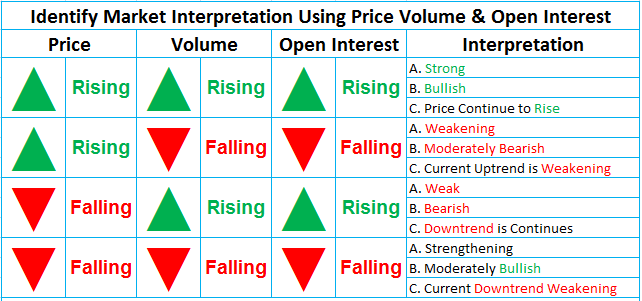

_Reference:  https://www.shubhlaxmicommodity.com/2019/07/ncdex-price-volume-open-interest.html_


# Model Solution
In this notebook, we provide a model solution to the project's stock and futures strategy. You can refer to this if you are stuck in any step while building your solution. The features and parameters added here are not exhaustive or fine-tuned. 

The model solution guides you through answering problem statements posed in the project. The notebook structure is as follows:
1. [Importing the libraries](#import)
2. [Handling the spot data ](#preprocessing)
3. [Running the  strategy and generating the trade book](#trades)
4. [Analyzing the strategy using a trade book ](#analysis)

In this guided project, we will trade instruments at the spot based on trend(indicated by spot prices) and confirm the momentum using the OI of the futures as indicated  in the First and Third Cases.

<a id='import'></a>
## Section 1: Importing the libraries

- This will be the first step for any Python project that you do.
- In this section, we import all required Python libraries used for computation.

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# For data visualisation
import matplotlib.pyplot as mp
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

<a id='preprocessing'></a>
## Section 2: Handling the Spot Data

In [2]:
# Reading the data from CSV file
df = pd.read_csv("PA.csv")

In [3]:
# Print the dataframe
df.head(5)

,date,open,high,low,close,volume,open_interest,contract,unadjusted_close
0,1977-01-03,88.956304,89.392364,88.607456,89.392364,5,457,197703,51.25
1,1977-01-04,89.130728,90.351697,89.130728,90.351697,4,457,197703,51.80
2,1977-01-05,89.305152,89.392364,89.305152,89.392364,5,439,197703,51.25
3,1977-01-06,90.264485,90.526121,90.264485,90.526121,10,450,197703,51.90
4,1977-01-07,92.444786,92.444786,92.444786,92.444786,5,450,197703,53.00


Now we need to extract the year and month for each data point. We will group later using the `df.groupby()` function because our future contracts have expiries, and we can't have any positions after that. So any trade initiated should be squared off before the expiration of the contract.

In [4]:
# We need to extract the year and month from the contract column. But the contract column we need to convert from int to string
# Because the dataframe from the expiry of the futures contracts

# Check the datatype for each column in the dataframe
df.dtypes

date                 object
open                float64
high                float64
low                 float64
close               float64
volume                int64
open_interest         int64
contract              int64
unadjusted_close    float64
dtype: object

In [5]:
# Convert contract column to string type
df["contract"]=df["contract"].values.astype(str)

In [6]:
# Check the datatype for each column in the dataframe
df.dtypes

date                 object
open                float64
high                float64
low                 float64
close               float64
volume                int64
open_interest         int64
contract             object
unadjusted_close    float64
dtype: object

In [7]:
# Extract year and month of the expiry
df['year'] = df.apply(lambda r : r['contract'][:4],axis = 1)
df['month'] = df.apply(lambda r : r['contract'][4:],axis = 1)

In [8]:
# Print the dataframe
df.head(5)

,date,open,high,low,close,volume,open_interest,contract,unadjusted_close,year,month
0,1977-01-03,88.956304,89.392364,88.607456,89.392364,5,457,197703,51.25,1977,03
1,1977-01-04,89.130728,90.351697,89.130728,90.351697,4,457,197703,51.80,1977,03
2,1977-01-05,89.305152,89.392364,89.305152,89.392364,5,439,197703,51.25,1977,03
3,1977-01-06,90.264485,90.526121,90.264485,90.526121,10,450,197703,51.90,1977,03
4,1977-01-07,92.444786,92.444786,92.444786,92.444786,5,450,197703,53.00,1977,03


In this section, we can use various technical indicators like RSI, MA, Bollinger Band, MACD, etc. for generating the 'Trend' column in the data frame

In this model solution, we would use  MA(5) crossover.

In [9]:
# Generate SMA(5) which is simple average of the last 5 days
df["SMA_5"] = df["unadjusted_close"].rolling(5).mean()

# Today’s SMA line is below the close price line and the previous-day SMA line is above the previous-day close line
bullish_condition_crossover = (df["unadjusted_close"].shift(1) < df["SMA_5"].shift(1)) & (df["unadjusted_close"] > df["SMA_5"])

# Make a new column in dataframe and set it as 1 if there is bullish crossover else 0
df['Trend'] = np.where(bullish_condition_crossover,1,0)

# Today’s SMA line is above the close price line and the previous-day SMA line is below the previous-day close line
bearish_condition_crossover = (df["unadjusted_close"].shift(1) > df["SMA_5"].shift(1)) & (df["unadjusted_close"] < df["SMA_5"])

# If there is bearish crossover make signal col -1  else let it be unchanged 
df['Trend'] = np.where(bearish_condition_crossover,-1,df['Trend'])

In [10]:
# Print the dataframe
df.head(5)

,date,open,high,low,close,volume,open_interest,contract,unadjusted_close,year,month,SMA_5,Trend
0,1977-01-03,88.956304,89.392364,88.607456,89.392364,5,457,197703,51.25,1977,03,NaN,0
1,1977-01-04,89.130728,90.351697,89.130728,90.351697,4,457,197703,51.80,1977,03,NaN,0
2,1977-01-05,89.305152,89.392364,89.305152,89.392364,5,439,197703,51.25,1977,03,NaN,0
3,1977-01-06,90.264485,90.526121,90.264485,90.526121,10,450,197703,51.90,1977,03,NaN,0
4,1977-01-07,92.444786,92.444786,92.444786,92.444786,5,450,197703,53.00,1977,03,51.84,0


In [11]:
# Print the number of trend signals
len(df[df['Trend']!=0])

2887

<a id='trade'></a>
## Step 3: Running the strategy and generating the trade book

### Strategy details 

- We have 4 different months of expiry: 03/06/09/12. So the main idea is to group our data based on these expiries.
- After grouping our data, for each group's initial 10 days we won't take any trade
- After 10 days, we would daily monitor the OI data of the nearest future expiry.
- Stock would be considered in momentum if today's OI is greater than the average of the last 10 days' OI.

ENTRY

- If the trend is bullish/bullish and there is sufficient momentum, we take the corresponding position in the spot  market

EXIT

- Target hit (If we achieve 5% profit)
- Not Sufficient Momentum (If current day's OI is less than last 10 days' OI average)
- Opposite Trend (If current trend is opposite of the previous trend)
- Expiry (Square-off at the expiry day in case there is an  open position)

### Working of the below code

We will loop over each of the dates in the data, take position whenever entry conditions are met, and square off positions (if any) when exit conditions are met, and update the completed trade in our trade book. 

We will backtest our strategy using the following steps:


**Step-1**: Create an empty list from which we will store our completed trades and generate our tradebook. We also store the four different types of future expiry in our dataset.

**Step-2**: We will group our data monthly and iterate through them individually. For each month, reset the count variable, store the last trading date for that month, and reset your position.

**Step-3**: We will iterate through each row of the given month. For the initial 10 days, we don't take any trade and store the average Open Interest for the last 10 days.

**Step-4**: After 10 days, if we don't have any position, we will check for entry signals. If any entry criteria is satisfied, we execute strategy and accordingly update our position. 

**Step-5**: If we have any existing positions, we will check for exit signals. If any exit criteria are satisfied, we execute strategy, square off our position, and reset our position.

**Step-6**: After a trade  is squared off, we store  all the corresponding details of the entire trade as a dictionary in the original list. 

**Step-7**: After we process all the data, we have a list of all completed trades as a dictionary. We convert this list into dataframe and generate our tradebook. 

### Strategy code

In [12]:
# Make a list of dictionaries which will be latter converted in a tradebook dataframe
new_trades = []
cnt  = 0

# Four types of expiries
expiries = ['03','06','09','12']

# Map each diary to a number
d = {'03':0, '06':1, '09':2, '12':3}

# Set the last expiry
# Last will be used to check next contract is valid
last = 3
for grouper_index, sliced_df in df.groupby(["year", "month"]):

  # If next contract is not in order so we won't  trade this 
  if(d[grouper_index[1]] != (last+1)%4):
    print("Not a valid Expiry. So won't take a trade here")

  else:

    # Initial day for new group 
    cnt  = 0

    # Average of last 10 days OI
    sliced_df['last_10_day_oi'] = sliced_df["open_interest"].rolling(10).mean()

    # New trade will be stored in a dictionary
    new_trade = {}
    pos = 0
    
    # Iterate through each row of the current month 
    for index, row in sliced_df.iterrows():

      # Check if 10 days have passed for the new group
      if(cnt > 9):

        # Average of last 10 days OI
        last_avg = row['last_10_day_oi']
        
        if pos == 0:

           # LONG TRADE ENTRY 

           # If bullish trend and sufficient momentum
           if (row['Trend'] > 0 and row['open_interest']>last_avg):

             # Update postion
             pos = 1 

             # Enter new trade log

             # Store date of entry
             new_trade['entry_day'] = row['date']

             # Store entry position
             new_trade['pos'] = pos

             # Store entry price
             new_trade['entry_price'] = row['unadjusted_close']

             # Store quantity transacted
             new_trade['qty'] = 1

           # SHORT TRADE ENTRY 

           # If bearish trend and sufficient momentum
           if (row['Trend'] < 0 and row['open_interest']>last_avg):

             # Update position
             pos = -1

             # Enter a new trade log
             new_trade['entry_day'] = row['date']
             new_trade['pos'] = pos
             new_trade['entry_price'] = row['unadjusted_close']
             new_trade['qty'] = 1

## ************************************************************************************************ ##

        # LONG TRADE SQUARE OFF SIGNAL DUE TO OPP TREND

        if pos == 1:

          # Trend Reverse
          if (row['Trend'] < 0):

            # Save complete trade log

            # Store date of exit
            new_trade['exit_day'] = row['date']

            # Store price at time of exit
            new_trade['exit_price'] = row['unadjusted_close']

            # Calculate profit
            new_trade['Pnl'] = new_trade['qty']*new_trade['pos']*(new_trade['exit_price']-new_trade['entry_price'])

            # Store reason for exit
            new_trade['Exit_Reason'] = "Trend Reverse"

            # Store trade
            new_trades.append(new_trade)

            # Set default values
            pos = 0
            new_trade = {}

            # Take fresh position in reversed trend
            pos = -1

            # Enter a new trade log
            new_trade['entry_day'] = row['date']
            new_trade['pos'] = pos
            new_trade['entry_price'] = row['unadjusted_close']
            new_trade['qty'] = 1
          
          # Check OI momentum declining
          elif (row['open_interest']<last_avg):

            # Save complete trade log
            new_trade['exit_day'] = row['date']
            new_trade['exit_price'] = row['unadjusted_close']
            new_trade['Pnl'] = new_trade['qty']*new_trade['pos']*(new_trade['exit_price']-new_trade['entry_price'])
            new_trade['Exit_Reason'] = "Square off as not sufficient momentum"
            new_trades.append(new_trade)
            pos = 0
            new_trade = {}


          # Check if the 5% take-profit target is hit
          elif row['unadjusted_close']>1.05*new_trade['entry_price']:

            ## Save complete trade log
            new_trade['exit_day'] = row['date']
            new_trade['exit_price'] = row['unadjusted_close']
            new_trade['Pnl'] = new_trade['qty']*new_trade['pos']*(new_trade['exit_price']-new_trade['entry_price'])
            new_trade['Exit_Reason'] = "Target"
            new_trades.append(new_trade)
            pos = 0
            new_trade = {}

          # Square-off at the expiry day in case there is an  open position
          elif(cnt == len(sliced_df)-1):

            # Save complete trade log
            new_trade['exit_day'] = row['date']
            new_trade['exit_price'] = row['unadjusted_close']
            new_trade['Pnl'] = new_trade['qty']*new_trade['pos']*(new_trade['exit_price']-new_trade['entry_price'])
            new_trade['Exit_Reason'] = "Expiry"
            new_trades.append(new_trade)

            # Set default values
            pos = 0
            new_trade = {}


## ************************************************************************************** **
          
        
 
        # SHORT TRADE SQUARE OFF SIGNAL OPP TREND

        if pos == -1:

          # Trend Reverse
          if (row['Trend'] > 0):

            # Save complete trade log
            new_trade['exit_day'] = row['date']
            new_trade['exit_price'] = row['unadjusted_close']
            new_trade['Pnl'] = new_trade['qty']*new_trade['pos']*(new_trade['exit_price']-new_trade['entry_price'])
            new_trade['Exit_Reason'] = "Trend Reverse"
            new_trades.append(new_trade)
            pos = 0
            new_trade = {}

            # Take fresh position in reversed trend
            pos = 1 

            # Enter new trade log
            new_trade['entry_day'] = row['date']
            new_trade['pos'] = pos
            new_trade['entry_price'] = row['unadjusted_close']
            new_trade['qty'] = 1


          # Check OI momentum declining
          elif (row['open_interest']<last_avg):

            # Save the complete trade log
            new_trade['exit_day'] = row['date']
            new_trade['exit_price'] = row['unadjusted_close']
            new_trade['Pnl'] = new_trade['qty']*new_trade['pos']*(new_trade['exit_price']-new_trade['entry_price'])
            new_trade['Exit_Reason'] = "Square off as not sufficient momentum"
            new_trades.append(new_trade)
            pos = 0
            new_trade = {}

          # Check if the 5% take-profit target is hit
          elif row['unadjusted_close']<0.95*new_trade['entry_price']:

            # Save complete trade log
            new_trade['exit_day'] = row['date']
            new_trade['exit_price'] = row['unadjusted_close']
            new_trade['Pnl'] = new_trade['qty']*new_trade['pos']*(new_trade['exit_price']-new_trade['entry_price'])
            new_trade['Exit_Reason'] = "Target"
            new_trades.append(new_trade)
            pos = 0
            new_trade = {}

          # Square-off at the expiry day in case there is an  open position 
          elif(cnt == len(sliced_df)-1):
      
          # Save complete trade log
            new_trade['exit_day'] = row['date']
            new_trade['exit_price'] = row['unadjusted_close']
            new_trade['Pnl'] = new_trade['qty']*new_trade['pos']*(new_trade['exit_price']-new_trade['entry_price'])
            new_trade['Exit_Reason'] = "Stoploss"
            new_trades.append(new_trade)
            pos = 0
            new_trade = {}
      
      # Increment cnt to go to next row of the sliced dateframe
      cnt = cnt + 1

  # Get net month whose expiry is available
  last = d[grouper_index[1]]

# Make a trade book of all the appended completed trades
new_tradebook = pd.DataFrame(data=new_trades)

Not a valid Expiry. So won't take a trade here
Not a valid Expiry. So won't take a trade here


In [13]:
# Print the tradeboook
new_tradebook

,entry_day,pos,entry_price,qty,exit_day,exit_price,Pnl,Exit_Reason
0,1977-01-28,-1,58.50,1,1977-02-02,58.10,0.40,Trend Reverse
1,1977-02-02,1,58.10,1,1977-02-04,59.05,0.95,Square off as not sufficient momentum
2,1977-02-09,-1,59.25,1,1977-02-11,58.50,0.75,Square off as not sufficient momentum
3,1977-02-17,1,58.25,1,1977-02-28,59.30,1.05,Expiry
4,1977-03-25,-1,56.50,1,1977-03-31,55.60,0.90,Square off as not sufficient momentum
...,...,...,...,...,...,...,...,...
1326,2020-10-19,1,2357.50,1,2020-10-23,2398.60,41.10,Trend Reverse
1327,2020-10-23,-1,2398.60,1,2020-10-28,2250.60,148.00,Target
1328,2020-11-11,-1,2316.80,1,2020-11-18,2354.00,-37.20,Trend Reverse
1329,2020-11-18,1,2354.00,1,2020-11-19,2319.80,-34.20,Trend Reverse


<a id='analysis'></a>
## Step 4: Analyzing the strategy using the trade book

We will compute key metrics to evaluate our strategy




In [14]:
# Get the trades with profit > 0, and by applying len function, we get the  number of winning trades
total_wins = len(new_tradebook[new_tradebook["Pnl"] > 0])

# Get the trades with profit < 0, and by applying len function, we get the number of losing trades
total_losses = len(new_tradebook[new_tradebook["Pnl"] < 0])

# Get the number of all trades
total_trades = len(new_tradebook)

# Number of wins trades/no of total trades
win_ratio = round(total_wins/total_trades,2)

# Number of loss trades/no of total trades
loss_ratio = round(total_losses / total_trades,2)

# Find all the profitable trades and adding their profit
total_win_amount = new_tradebook[new_tradebook["Pnl"] > 0]["Pnl"].sum()

# Total profit / Number of winning trades
average_profit_in_profitable_trade = total_win_amount / total_wins

# Find all the losing trades and adding their losses
total_loss_amount = new_tradebook[new_tradebook["Pnl"] < 0]["Pnl"].sum()

# Total loss/Number of losing trades
average_loss_in_loss_trade = total_loss_amount / total_losses

# Average profit/Average loss
payoff_ratio = average_profit_in_profitable_trade / average_loss_in_loss_trade

# Win ratio * Average profit/Loss ratio * Average loss
trade_expectancy = (win_ratio * average_profit_in_profitable_trade) / (loss_ratio * average_loss_in_loss_trade)

# Store the important metrics in a list
data = [[win_ratio,loss_ratio,payoff_ratio,trade_expectancy]]

# Convert list into dataframe
df = pd.DataFrame(data,columns=['win_ratio','loss_ratio','payoff_ratio','trade_expectancy'], index=['value'])

# Print the dataframe
df

,win_ratio,loss_ratio,payoff_ratio,trade_expectancy
value,0.39,0.55,-1.579621,-1.120095


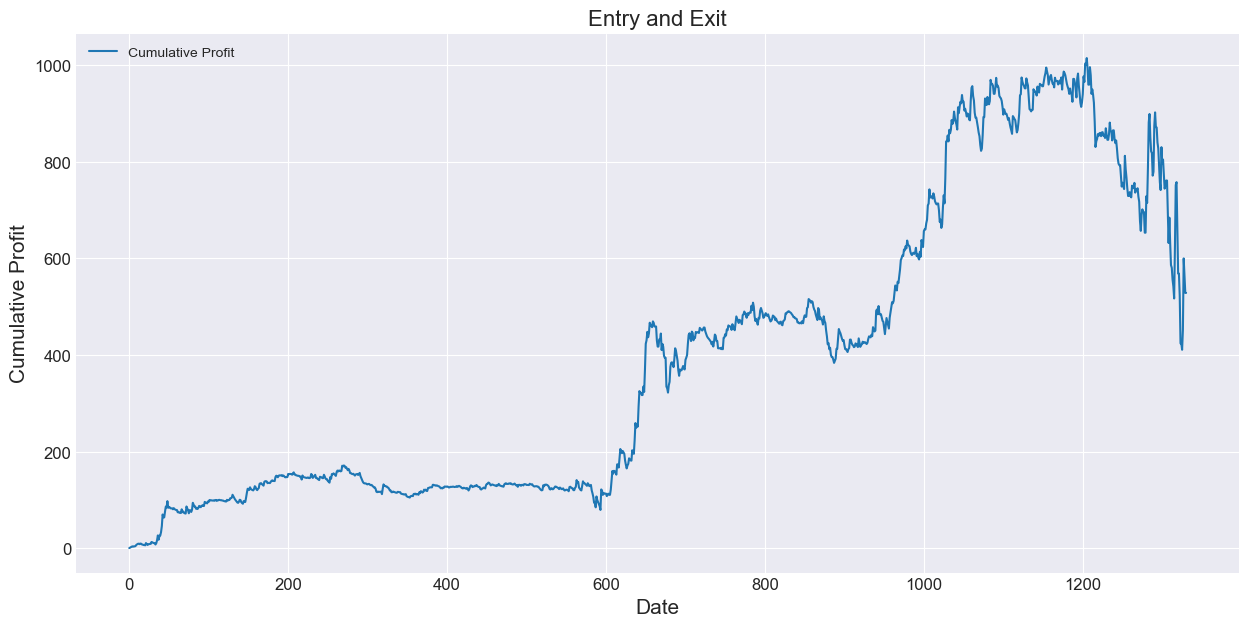

In [15]:
# Generate a column for cumulative profit
new_tradebook['Cumulative Profit'] = new_tradebook['Pnl'].cumsum()

# Define the figure size for the plot
plt.figure(figsize=(15, 7))

# Plot the close price of the underlying
profit = new_tradebook['Cumulative Profit'].plot()

# Set the title and axis labels
profit.set_title('Entry and Exit', fontsize=16)
profit.set_ylabel('Cumulative Profit', fontsize=15)
profit.set_xlabel('Date', fontsize=15)

# Add a legend to the axis
plt.legend(loc='best')

# Define the tick size for the x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()